In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [10]:
#импортируем все нужные бибилиотеки и создадим datafrime с данными которые нужно рассмотреть
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
file_path = "C:/Users/Dmitrij/Downloads/Flats.xls"
full_data = pd.read_excel(file_path)
full_data = full_data[(full_data.ROOM==3) | (full_data.ROOM==2)]
full_data.index = np.arange(len(full_data))
data_log_X = full_data.drop(['PRICE','WALK','BRICK','TEL','BAL','FLOOR','ROOM'],axis=1)
data_log_y = full_data.ROOM
X=full_data.drop(['PRICE','WALK','BRICK','TEL','BAL','FLOOR','ROOM'],axis=1)
X

,LIVSQ,APPEN,KITSQ,DIST,METRDIST
0,36.2,18.9,9.5,1.500,5.0
1,30.3,12.1,8.0,1.500,5.0
2,30.0,9.2,11.8,1.500,5.0
3,29.0,8.0,5.0,4.500,5.0
4,30.0,8.7,6.0,4.500,15.0
...,...,...,...,...,...
279,56.0,18.0,10.0,8.125,6.0
280,39.0,18.0,9.0,18.750,10.0
281,51.0,20.0,8.0,15.625,10.0
282,50.0,18.0,12.0,5.000,5.0


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [119]:
pca_model = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=2))])
principalComponents = pca_model.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component_1', 'principal_component_2'])
principalDf['target']=data_log_y
principalDf

,principal_component_1,principal_component_2,target
0,0.864648,-1.647861,2
1,-0.694193,-1.763292,2
2,0.054038,-1.868389,2
3,-2.171523,-1.349532,2
4,-1.778139,0.534151,2
...,...,...,...
279,1.894104,-0.343380,3
280,0.427598,1.755046,3
281,1.107406,1.477272,3
282,2.198214,-1.068898,3


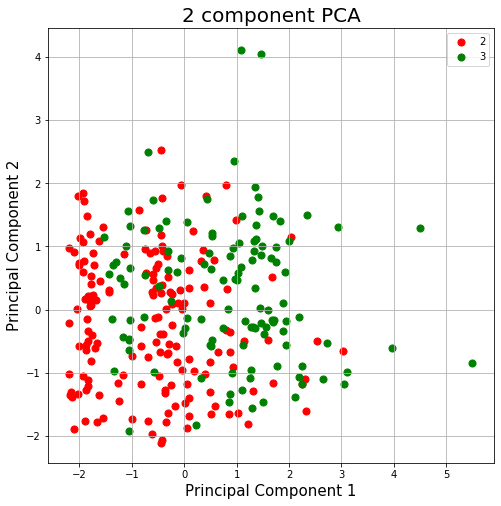

In [97]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [2,3]
colors = ['r','g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf.target == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal_component_1']
               , principalDf.loc[indicesToKeep, 'principal_component_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [98]:
pca_model['pca'].explained_variance_ratio_

array([0.39355087, 0.2356138 ])

In [99]:
pca_model['pca'].components_

array([[ 0.54052013,  0.62473627,  0.5555343 , -0.09356641, -0.0130215 ],
       [ 0.09694965,  0.06489878, -0.03378745,  0.69402354,  0.70963275]])

# 2 вариант 

In [148]:
Xcenter = X.apply(lambda x: (x - x.mean())/np.std(x))
cov = np.cov(Xcenter)

In [153]:
_,vecs = np.linalg.eig(cov)
v = vecs[:,:2]

In [156]:
Xnew = np.dot(v.T,Xcenter) 
df=pd.DataFrame()
df['xnew0']=Xnew[0]
df['xnew1']=Xnew[1]
df['target']=full_data.ROOM
df

,xnew0,xnew1,target
0,8.916581+0.000000j,0.031846+0.000000j,2
1,10.794273+0.000000j,0.650333+0.000000j,2
2,10.395825+0.000000j,-0.377559+0.000000j,2
3,-9.910839+0.000000j,10.090177+0.000000j,2
4,-8.223347+0.000000j,-11.444286+0.000000j,2


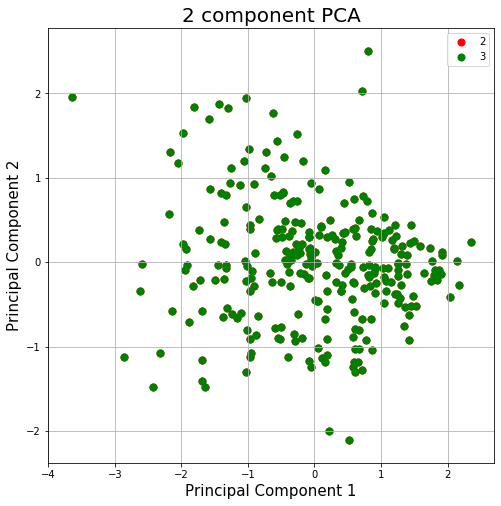

In [141]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [2,3]
colors = ['r','g']
for target, color in zip(targets,colors):
    indicesToKeep = df.target == target
    ax.scatter(df.xnew0
               ,df.xnew1
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Регрессия

In [60]:
log_model = Pipeline([('scaler', StandardScaler()),('log',LogisticRegression(random_state=42))])
log_cv_accuracy = cross_val_score(log_model, data_log_X, data_log_y, cv=cv, scoring='accuracy')
log_cv_recall = cross_val_score(log_model, data_log_X, data_log_y, cv=cv, scoring='recall_macro')
print('recall={:2f} accuracy={:2f}'.format(log_cv_recall.mean(),(log_cv_accuracy.mean())))

recall=0.962879 accuracy=0.964850


In [109]:
for split_idx,(train_idx,test_idx) in enumerate(cv.split(data_log_X,data_log_y)):
    X_train,X_test = data_log_X.iloc[train_idx],data_log_X.iloc[test_idx]
    y_train,y_test = data_log_y[train_idx],data_log_y[test_idx]
    log_model.fit(X_train,y_train)
    #print('X_test\n{}\n'.format(X_test))
    #print('prediction:\n{} \n probabylity:\n{}'.format(log_model.predict(X_test),log_model.predict_proba(X_test)))

In [62]:
log_model2 = Pipeline([('scaler', StandardScaler()),('pca',PCA(n_components=2)),('log',LogisticRegression(random_state=42))])
log_cv_accuracy2 = cross_val_score(log_model2, data_log_X, data_log_y, cv=cv, scoring='accuracy')
log_cv_recall2 = cross_val_score(log_model2, data_log_X, data_log_y, cv=cv, scoring='recall_macro')
print('recall={:2f} accuracy={:2f}'.format(log_cv_recall2.mean(),(log_cv_accuracy2.mean())))

recall=0.751989 accuracy=0.764035


In [102]:
for split_idx,(train_idx,test_idx) in enumerate(cv.split(data_log_X,data_log_y)):
    X_train,X_test = data_log_X.iloc[train_idx],data_log_X.iloc[test_idx]
    y_train,y_test = data_log_y[train_idx],data_log_y[test_idx]
    log_model2.fit(X_train,y_train)
    #print('X_test\n{}\n'.format(X_test))
    #print('prediction:\n{} \n probabylity:\n{}'.format(log_model2.predict(X_test),log_model2.predict_proba(X_test)))